### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

!pip install razdel
from razdel import tokenize  #https://github.com/natasha/razdel

!pip install pymorphy2
import pymorphy2  


In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
news

,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...
3,4898,Главный тренер «Кубани» Юрий Красножан прокомм...
4,4899,Решением попечительского совета владивостокско...
...,...,...
26995,513441,Ученые Токийского университета морских наук и ...
26996,513442,Главой кафедры отечественной истории XX века и...
26997,513443,Американские ученые уточнили возраст расположе...
26998,513444,За последние 50 лет тропический углеродный цик...


In [11]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\HOME\AppData\Local\Temp\ipykernel_11940\2296537027.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: total: 19.9 s
Wall time: 24 s


In [12]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: total: 2min 25s
Wall time: 3min 12s


А теперь в 3 строчки обучим нашу модель

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [14]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [15]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: total: 24 s
Wall time: 26.4 s


In [16]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [17]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(10, 0.23764153), (16, 0.259884), (17, 0.03761231), (22, 0.44614235)]

In [18]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: военный армия экипаж год сила топливо nn
topic_1: суд дело квартира следствие налог год банк
topic_2: украина украинский глава президент который свой это
topic_3: млрд год рост бюджет объём китай китайский
topic_4: человек это который nn гражданин год день
topic_5: кг золото широко рекорд точнее показ шутка
topic_6: риск банк торговый участок смерть карта подчёркивать
topic_7: россия российский это год который страна nn
topic_8: год который исследование обнаружить данные тело мужчина
topic_9: космос планета земля товар вероятно физика теория
topic_10: это который год мочь свой весь всё
topic_11: исследование год проект цена фонд предполагать миссия
topic_12: научный наука министерство грузия потребность год правовой
topic_13: год компания млн рубль тыс банк снижение
topic_14: поверхность век городской сон концепция актёр вложить
topic_15: пенсия сектор превысить год площадь годовой кожа
topic_16: километр дыра индия лёд последствие игра климат
topic_17: температура рак фестива

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [19]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [20]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.000000,0.241792,0.0,0.0,0.0,0.49891,0.122408,0.0,...,0.000000,0.000000,0.000000,0.025086,0.022772,0.000000,0.0,0.082085,0.000000,0.0
1,4896,0.0,0.065459,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.441331,0.000000,0.000000,0.0,0.207256,0.264941,0.0
2,4897,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,...,0.000000,0.259967,0.037609,0.000000,0.000000,0.000000,0.0,0.446112,0.000000,0.0
3,4898,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,...,0.014727,0.000000,0.000000,0.193022,0.105458,0.000000,0.0,0.110875,0.062516,0.0
4,4899,0.0,0.000000,0.444238,0.0,0.0,0.0,0.00000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.230099,0.000000,0.193147,0.0,0.000000,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [21]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [22]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [23]:
doc_dict[293622]

array([0.        , 0.09883951, 0.        , 0.        , 0.22414766,
       0.        , 0.        , 0.24491099, 0.05518931, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.08442485,
       0.        , 0.01615086, 0.        , 0.17394681, 0.03750965,
       0.        , 0.        , 0.        , 0.        , 0.05516016])

In [24]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [25]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [26]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.04568814, 0.        , 0.03688692,
       0.        , 0.        , 0.23117737, 0.02044412, 0.        ,
       0.23521637, 0.01525879, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04739883, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [27]:
#users['articles'].iloc[33]

In [28]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [29]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.009149,0.000000,0.0,0.157749,0.0,0.000000,0.178827,0.027595,...,0.0,0.0,0.0,0.215953,0.0,0.0,0.0,0.000000,0.0,0.0
1,u108690,0.0,0.000000,0.108723,0.0,0.197693,0.0,0.000000,0.198568,0.009242,...,0.0,0.0,0.0,0.076660,0.0,0.0,0.0,0.000000,0.0,0.0
2,u108339,0.0,0.051599,0.000000,0.0,0.221233,0.0,0.009865,0.271801,0.120047,...,0.0,0.0,0.0,0.038860,0.0,0.0,0.0,0.016145,0.0,0.0


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [30]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [31]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.009149,0.000000,0.0,0.157749,0.0,0.000000,0.178827,0.027595,...,0.0,0.0,0.215953,0.0,0.0,0.0,0.000000,0.0,0.0,0
1,u108690,0.0,0.000000,0.108723,0.0,0.197693,0.0,0.000000,0.198568,0.009242,...,0.0,0.0,0.076660,0.0,0.0,0.0,0.000000,0.0,0.0,1
2,u108339,0.0,0.051599,0.000000,0.0,0.221233,0.0,0.009865,0.271801,0.120047,...,0.0,0.0,0.038860,0.0,0.0,0.0,0.016145,0.0,0.0,1


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [33]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [34]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [35]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.03931693, 0.00825567, 0.49909482, 0.33795685, 0.0775091 ,
       0.03750802, 0.14661495, 0.44669774, 0.31477905, 0.03542747])

In [36]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [37]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.268548, F-Score=0.704, Precision=0.644, Recall=0.776


In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1650  105]
 [  56  189]]


NameError: name 'itertools' is not defined

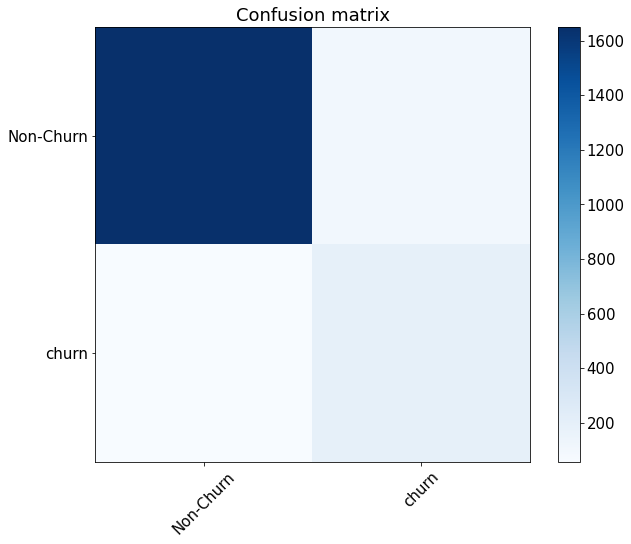

In [39]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [40]:
roc_auc = roc_auc_score(y_test, preds)

In [41]:
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])

metrics_df = metrics_df.append({
    'model': "mediana",
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

C:\Users\HOME\AppData\Local\Temp\ipykernel_11940\817396265.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


3.Повторить п.2, но используя уже не медиану, а max

In [42]:
get_user_embedding_max(user_articles_list)

array([0.3247866 , 0.49944866, 0.23932879, 0.09032274, 0.16263148,
       0.        , 0.01173843, 0.42690361, 0.12838507, 0.        ,
       0.36790577, 0.09324732, 0.        , 0.13688149, 0.        ,
       0.        , 0.01243845, 0.        , 0.28454906, 0.16102664,
       0.02908729, 0.        , 0.        , 0.        , 0.07552332])

In [43]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.019490,0.142755,0.334711,0.000000,0.542679,0.0,0.000000,0.324667,0.151784,...,0.049546,0.016151,0.000000,0.510909,0.037510,0.0518,0.012916,0.081453,0.027492,0.055160
1,u108690,0.152638,0.071115,0.223648,0.089600,0.291579,0.0,0.010562,0.388380,0.243526,...,0.020773,0.034065,0.000000,0.111100,0.045773,0.0000,0.000000,0.000000,0.102836,0.045200
2,u108339,0.219073,0.098306,0.162564,0.155009,0.360525,0.0,0.042050,0.536812,0.211976,...,0.016038,0.012209,0.033816,0.225734,0.021726,0.0000,0.000000,0.064462,0.000000,0.037268


In [44]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.019490,0.142755,0.334711,0.000000,0.542679,0.0,0.000000,0.324667,0.151784,...,0.016151,0.000000,0.510909,0.037510,0.0518,0.012916,0.081453,0.027492,0.055160,0
1,u108690,0.152638,0.071115,0.223648,0.089600,0.291579,0.0,0.010562,0.388380,0.243526,...,0.034065,0.000000,0.111100,0.045773,0.0000,0.000000,0.000000,0.102836,0.045200,1
2,u108339,0.219073,0.098306,0.162564,0.155009,0.360525,0.0,0.042050,0.536812,0.211976,...,0.012209,0.033816,0.225734,0.021726,0.0000,0.000000,0.064462,0.000000,0.037268,1


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [46]:
model = LogisticRegression()
# обучим 
model.fit(X_train, y_train)

LogisticRegression()

In [47]:
# наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22159874, 0.00093528, 0.74283034, 0.44454735, 0.1458227 ,
       0.00224387, 0.09299062, 0.31294503, 0.02777922, 0.28869163])

In [48]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.3239185035430777, F-Score=0.725, Precision=0.708, Recall=0.743


In [49]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9601488458631315

In [50]:
metrics_df = metrics_df.append({
    'model': 'max',
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

C:\Users\HOME\AppData\Local\Temp\ipykernel_11940\1487295037.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


5.

In [51]:
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mediana,0.268548,0.703704,0.644068,0.77551,0.959428
1,max,0.323919,0.7251,0.708171,0.742857,0.960149


6.

In [52]:
В данном случае максимальный показал себя более эффективно, потому что он брал наиболее подходящую тему для пользователя, а не медианную. Но при большем числе тем эта статистика поменяется

SyntaxError: invalid syntax (945836088.py, line 1)

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk